# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:

1. **Handle Skewed Variables** - Log-transform `residual sugar`, `total sulfur dioxide`, `chlorides`
2. **Outlier Treatment** - IQR-capping for extreme acidity/sulphates 
3. **Feature Engineering** - Create acidity ratios and interaction features
4. **Feature Selection** - Keep high-signal features, evaluate low-signal ones
5. **Scaling** - StandardScaler for distance-based models
6. **Target Handling** - Classification approach with stratified splits

**Key EDA Evidence to Implement**

- **High-signal features**: `alcohol`, `volatile acidity`, `sulphates`, `citric acid`, `density`, `chlorides`
- **Low-signal features**: `residual sugar`, `free sulfur dioxide` (evaluate for removal)
- **Skewed variables**: `residual sugar`, `total sulfur dioxide`, `chlorides` (log-transform)
- **Feature engineering**: Acidity ratios, alcohol-acidity interactions, fermentation efficiency


#### **1. Import Libraries and Load Data**

In [28]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [29]:
# Load in the dataset

zip_path = r"C:\Users\ncc777\Downloads\wine+quality.zip"

with zipfile.ZipFile(zip_path) as z:
    with z.open('winequality-white.csv') as f:
        white_wine = pd.read_csv(f,sep = ";")
    #zip_ref.extractall("Datasets")


In [30]:
with zipfile.ZipFile(zip_path) as z:
    with z.open('winequality-red.csv') as f:
        red_wine = pd.read_csv(f,sep = ";")

In [31]:
df = red_wine 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### **2. EDA-Based Data Quality Assessment**

Based on EDA findings, let's assess the specific issues identified

In [32]:
# Create a copy for preprocessing
df_processed = df.copy()



# 1. Check for missing values (EDA showed no missing values)
print("\n1. Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")

# 3. Check skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ['residual sugar', 'total sulfur dioxide', 'chlorides']
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")

# 4. Check correlation with target (EDA evidence)
print("\n4. Correlation with Quality (EDA Evidence):")
correlations = df_processed.corr()['quality'].sort_values(key=abs, ascending=False)
print("High-signal features (|correlation| > 0.2):")
high_signal = correlations[abs(correlations) > 0.2].drop('quality')
for feature, corr in high_signal.items():
    print(f"  {feature}: {corr:.3f}")

print("\nLow-signal features (|correlation| < 0.1):")
low_signal = correlations[abs(correlations) < 0.1]
for feature, corr in low_signal.items():
    print(f"  {feature}: {corr:.3f}")



1. Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 240
Percentage of duplicates: 15.01%

3. Skewness Analysis (EDA identified right-skewed variables):
residual sugar: skewness = 4.536 (right-skewed)
total sulfur dioxide: skewness = 1.514 (right-skewed)
chlorides: skewness = 5.675 (right-skewed)

4. Correlation with Quality (EDA Evidence):
High-signal features (|correlation| > 0.2):
  alcohol: 0.476
  volatile acidity: -0.391
  sulphates: 0.251
  citric acid: 0.226

Low-signal features (|correlation| < 0.1):
  pH: -0.058
  free sulfur dioxide: -0.051
  residual sugar: 0.014


#### **3. Handle Duplicates**


In [33]:
# Remove duplicates if any (EDA didn't report duplicates, but let's be thorough)
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("✓ No duplicates to remove (as expected from EDA)")


Removing 240 duplicate rows...
Dataset shape after removing duplicates: (1359, 12)


#### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [34]:
# Log-transform skewed variables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

# Variables to log-transform based on EDA findings
skewed_vars = ['residual sugar', 'total sulfur dioxide', 'chlorides']

for var in skewed_vars:
    if var in df_processed.columns:
        # Check if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <= 0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log(df_processed[var])
            print(f"✓ {var}: Applied log transformation")
        
        # Check skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])


=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ residual sugar: Applied log transformation
  Original skewness: 4.543 → Transformed skewness: 1.763
✓ total sulfur dioxide: Applied log transformation
  Original skewness: 1.539 → Transformed skewness: -0.078
✓ chlorides: Applied log transformation
  Original skewness: 5.496 → Transformed skewness: 1.886

Dataset shape after log transformation: (1359, 15)
New log-transformed columns: ['residual sugar_log', 'total sulfur dioxide_log', 'chlorides_log']


#### **5. Outlier Treatment (EDA Recommendation)**

Based on EDA findings, handle outliers using IQR-capping metho

In [35]:
# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
print("EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points")

# Define numerical columns (excluding target)
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'quality' in numerical_cols:
    numerical_cols.remove('quality')

print(f"Treating outliers in {len(numerical_cols)} numerical features...")

# Apply IQR-capping method
outliers_capped = 0
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    
    if outliers_before > 0:
        # Cap outliers
        df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
        df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
        outliers_capped += outliers_before
        print(f"✓ {col}: Capped {outliers_before} outliers")

print(f"\nTotal outliers capped: {outliers_capped}")
print(f"Dataset shape after outlier treatment: {df_processed.shape}")


=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points
Treating outliers in 14 numerical features...
✓ fixed acidity: Capped 41 outliers
✓ volatile acidity: Capped 19 outliers
✓ citric acid: Capped 1 outliers
✓ residual sugar: Capped 126 outliers
✓ chlorides: Capped 87 outliers
✓ free sulfur dioxide: Capped 26 outliers
✓ total sulfur dioxide: Capped 45 outliers
✓ density: Capped 35 outliers
✓ pH: Capped 28 outliers
✓ sulphates: Capped 55 outliers
✓ alcohol: Capped 12 outliers
✓ residual sugar_log: Capped 96 outliers
✓ chlorides_log: Capped 102 outliers

Total outliers capped: 673
Dataset shape after outlier treatment: (1359, 15)


#### **6. Feature Engineering**

Implement the specific feature engineering recommendations from the EDA report

In [36]:
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")

# 1. Acidity ratio: fixed_to_volatile = fixed_acidity / volatile_acidity
# EDA rationale: Quality improves when stable acids (fixed) dominate over volatile (harsh) acids
print("1. Creating acidity ratio features...")
eps = 1e-6  # Small constant to avoid divide-by-zero

df_processed['FA_to_VA_ratio'] = df_processed['fixed acidity'] / (df_processed['volatile acidity'] + eps)
print("- FA_to_VA_ratio: fixed_acidity / volatile_acidity")

# 2. Citric balance: citric_over_total_acid = citric_acid / (fixed_acidity + volatile_acidity + eps)
# EDA rationale: Citric acid adds freshness, normalize by total acid captures relative freshness
df_processed['citric_over_total_acid'] = df_processed['citric acid'] / (df_processed['fixed acidity'] + df_processed['volatile acidity'] + eps)
print("- citric_over_total_acid: citric_acid / (fixed_acidity + volatile_acidity)")

# 3. Alcohol–Acidity interaction: alcohol / volatile_acidity
# EDA rationale: High alcohol only signals high quality when volatile acidity is low
df_processed['alcohol_acid_interaction'] = df_processed['alcohol'] / (df_processed['volatile acidity'] + eps)
print("- alcohol_acid_interaction: alcohol / volatile_acidity")

# 4. Fermentation efficiency: alcohol_density_ratio = alcohol / density
# EDA rationale: Density decreases while alcohol increases with quality - captures fermentation completeness
df_processed['alcohol_density_ratio'] = df_processed['alcohol'] / (df_processed['density'] + eps)
print("- alcohol_density_ratio: alcohol / density")

# 5. Sulphate–citric interaction: sulphates * citric_acid
# EDA rationale: Sulphates and citric acid jointly correlate with perceived freshness and preservation
df_processed['sulphate_citric_interaction'] = df_processed['sulphates'] * df_processed['citric acid']
print("- sulphate_citric_interaction: sulphates * citric_acid")

# 6. Total acidity (sum of all acidity measures)
df_processed['total_acidity'] = df_processed['fixed acidity'] + df_processed['volatile acidity'] + df_processed['citric acid']
print("- total_acidity: sum of all acidity measures")

# 7. pH-acidity balance (EDA showed pH and acidity are chemically related)
df_processed['ph_acidity_balance'] = df_processed['pH'] * df_processed['total_acidity']
print("- ph_acidity_balance: pH * total_acidity")

print(f"\nDataset shape after feature engineering: {df_processed.shape}")
print(f"New engineered features: {[col for col in df_processed.columns if col not in df.columns]}")


FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS
1. Creating acidity ratio features...
- FA_to_VA_ratio: fixed_acidity / volatile_acidity
- citric_over_total_acid: citric_acid / (fixed_acidity + volatile_acidity)
- alcohol_acid_interaction: alcohol / volatile_acidity
- alcohol_density_ratio: alcohol / density
- sulphate_citric_interaction: sulphates * citric_acid
- total_acidity: sum of all acidity measures
- ph_acidity_balance: pH * total_acidity

Dataset shape after feature engineering: (1359, 22)
New engineered features: ['residual sugar_log', 'total sulfur dioxide_log', 'chlorides_log', 'FA_to_VA_ratio', 'citric_over_total_acid', 'alcohol_acid_interaction', 'alcohol_density_ratio', 'sulphate_citric_interaction', 'total_acidity', 'ph_acidity_balance']


#### **7. Feature Selection**

Based on EDA correlation analysis, select high-signal features and evaluate low-signal ones

In [37]:
# Feature selection based on EDA correlation evidence
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# Separate features and target
X = df_processed.drop('quality', axis=1)
y = df_processed['quality']

print(f"Total features available: {X.shape[1]}")

# EDA-identified high-signal features (|correlation| > 0.2)
high_signal_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'density', 'chlorides']
print(f"\nEDA-identified high-signal features: {high_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1) 
low_signal_features = ['residual sugar', 'free sulfur dioxide']
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are actually available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# Create feature sets for evaluation
print("\n=== FEATURE SETS FOR EVALUATION ===")

# Set 1: All original features (excluding low-signal)
features_exclude_low_signal = [col for col in X.columns if col not in low_signal_features]
print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = available_high_signal + [col for col in X.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Let's use Set 2 (high-signal + engineered) as recommended by EDA
selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)


=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 21

EDA-identified high-signal features: ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'density', 'chlorides']
EDA-identified low-signal features: ['residual sugar', 'free sulfur dioxide']

Available high-signal features: ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'density', 'chlorides']
Available low-signal features: ['residual sugar', 'free sulfur dioxide']

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Exclude low-signal features: 19 features
Set 2 - High-signal + engineered: 17 features
Set 3 - All features: 21 features

✓ Selected feature set: 17 features
Selected features: ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'density', 'chlorides', 'total sulfur dioxide', 'residual sugar_log', 'total sulfur dioxide_log', 'chlorides_log', 'FA_to_VA_ratio', 'citric_over_total_acid', 'alcohol_acid_interaction', 'alcohol_density_ratio', 'sulphate_citric_interactio

#### **8. Data Splitting (Stratified)**


Based on EDA findings about class imbalance, use stratified splitting


In [38]:
# Stratified data splitting based on EDA findings about class imbalance
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

# Select the chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f}%)")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())
print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())


=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (1359, 17)

Data split results:
Training set: (815, 17) (60.0%)
Validation set: (272, 17) (20.0%)
Test set: (272, 17) (20.0%)

Class distribution verification:
Training set quality distribution:
quality
3      6
4     31
5    346
6    321
7    100
8     11
Name: count, dtype: int64

Validation set quality distribution:
quality
3      2
4     11
5    115
6    107
7     34
8      3
Name: count, dtype: int64

Test set quality distribution:
quality
3      2
4     11
5    116
6    107
7     33
8      3
Name: count, dtype: int64


#### **9. Feature Scaling**


Apply StandardScaler as recommended by EDA for distance-based models.


In [39]:
# Apply StandardScaler as recommended by EDA
print("=== FEATURE SCALING (STANDARD SCALER) ===")
print("EDA recommended StandardScaler for distance-based models")

# Fit scaler on training data only (to avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied successfully!")
print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

# Verify scaling worked correctly
print(f"\nScaling verification:")
print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models
✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 1.0006
Validation set scaled - Mean: 0.0080, Std: 0.9902
Test set scaled - Mean: -0.0096, Std: 0.9558

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: True


#### **10. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. density: 0.100
 2. alcohol_density_ratio: 0.098
 3. alcohol: 0.097
 4. chlorides: 0.063
 5. chlorides_log: 0.060
 6. ph_acidity_balance: 0.055
 7. FA_to_VA_ratio: 0.053
 8. total_acidity: 0.051
 9. volatile acidity: 0.050
10. citric acid: 0.038

Engineered features in top 10: ['chlorides_log', 'FA_to_VA_ratio', 'alcohol_density_ratio', 'total_acidity', 'ph_acidity_balance']


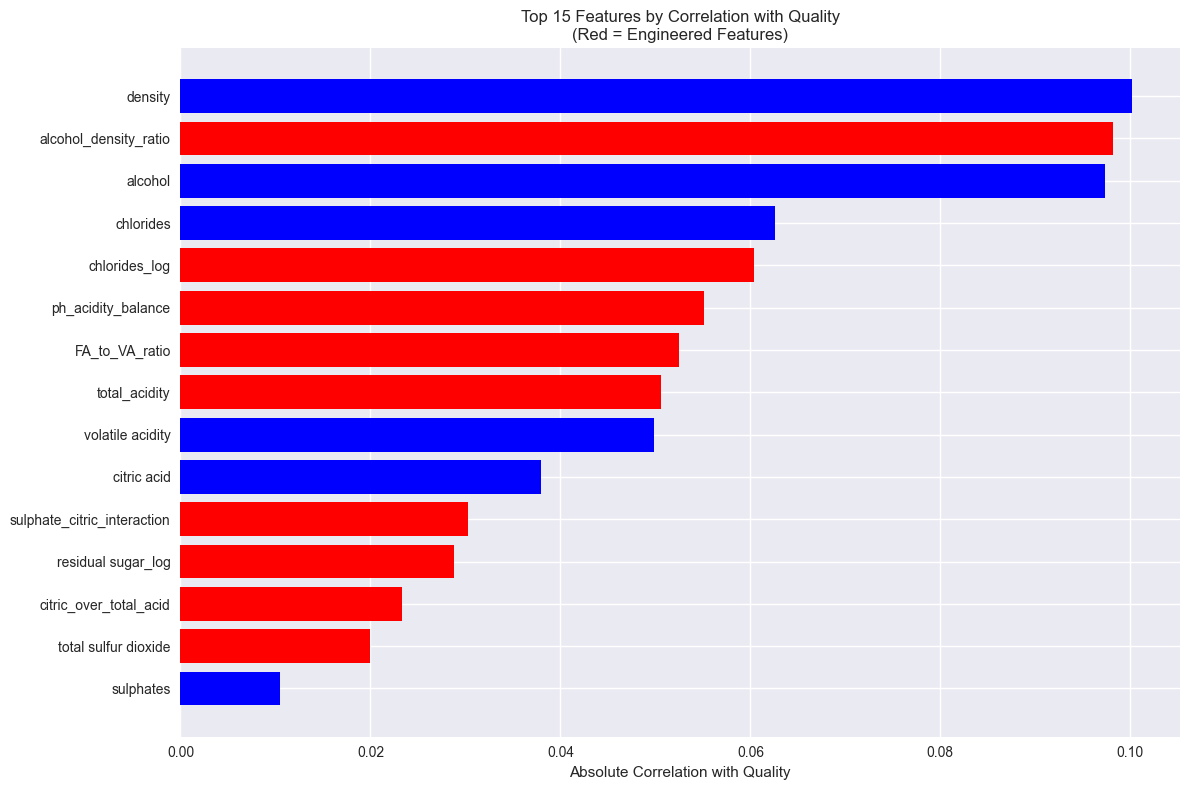


✓ Feature importance analysis completed
✓ 5 engineered features in top 10


In [40]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Quality')
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


#### **11. Save Preprocessed Data**


Save all preprocessed datasets and preprocessing objects for modeling

In [41]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_val_scaled.to_csv('X_val_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'val_samples': X_val_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ['residual sugar', 'total sulfur dioxide', 'chlorides']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


#### **12. Preprocessing Summary**

In [42]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Validation samples: {X_val_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, duplicates handled)")
print("> Log-transformation of skewed variables (residual sugar, total SO₂, chlorides)")
print("> Outlier treatment using IQR-capping method")
print("> Feature engineering based on EDA recommendations:")
print("  - FA_to_VA_ratio (fixed acidity / volatile acidity)")
print("  - citric_over_total_acid (citric acid / total acidity)")
print("  - alcohol_acid_interaction (alcohol / volatile acidity)")
print("  - alcohol_density_ratio (alcohol / density)")
print("  - sulphate_citric_interaction (sulphates * citric acid)")
print("  - total_acidity (sum of all acidity measures)")
print("  - ph_acidity_balance (pH * total acidity)")
print("> Feature selection (high-signal features + engineered features)")
print("> Stratified data splitting (preserves class distribution)")
print("> StandardScaler applied (EDA recommendation for distance-based models)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> High-signal features prioritized: alcohol, volatile acidity, sulphates, citric acid")
print("> Low-signal features excluded: residual sugar, free sulfur dioxide")
print("> Skewed variables log-transformed as recommended")
print("> Acidity ratios created based on grouped means analysis")
print("> Alcohol-acidity interactions based on trivariate analysis")
print("> Fermentation efficiency features based on density-alcohol relationship")


print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")


.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (1599, 12)
Final processed dataset shape: (1359, 22)
Selected features: 17
Training samples: 815
Validation samples: 272
Test samples: 272

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, duplicates handled)
> Log-transformation of skewed variables (residual sugar, total SO₂, chlorides)
> Outlier treatment using IQR-capping method
> Feature engineering based on EDA recommendations:
  - FA_to_VA_ratio (fixed acidity / volatile acidity)
  - citric_over_total_acid (citric acid / total acidity)
  - alcohol_acid_interaction (alcohol / volatile acidity)
  - alcohol_density_ratio (alcohol / density)
  - sulphate_citric_interaction (sulphates * citric acid)
  - total_acidity (sum of all acidity measures)
  - ph_acidity_balance (pH * total acidity)
> Feature selection (high-signal features + engineered features)
> Stratified data splitting (preserves class distribution